# Train RNNs on row signals with sliding window

In [6]:
import numpy as np

from keras.models import Sequential
from keras import layers
from keras import regularizers
from readers_preprocess import read_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib notebook


In [7]:
def flilter_chanels(data, chanels):
    fillterd_data = []
    for seq in data:
        fillterd_data.append(seq[:,chanels])
    return np.array(fillterd_data)
        

def cut_data(data, anots):
    seq_len = 128
    step = 64
    X = []
    y = []
    for sample_idx in range(len(data)):
        sample = data[sample_idx]
        for i in range(seq_len, sample.shape[0], step):
            X.append(sample[i-seq_len:i, :])
            y.append(anots[sample_idx])
    X, y = shuffle(X, y)
    return np.array(X), np.array(y)


def rnn_model(data, target, hiden_size, regularization):
    timesteps = 128
    num_classes = target.shape[1]
    _, num_chanels = data[0].shape
    model = Sequential()
    model.add(layers.GRU(int(hiden_size), input_shape=(int(timesteps), int(num_chanels)), kernel_regularizer=regularizers.l1(regularization)))


    model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(regularization/100)))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def rnn_2layers_model(data, target, hiden_size, reg):
    timesteps = 128
    num_classes = target.shape[1]
    _, num_chanels = data[0].shape

    model = Sequential()
    model.add(layers.GRU(hiden_size, return_sequences=False, input_shape=(timesteps, num_chanels), kernel_regularizer=regularizers.l1(reg)))
    model.add(layers.Dense(int(hiden_size/2), kernel_regularizer=regularizers.l1(reg), activation='elu'))


    model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(reg/100)))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_nn(X_train, y_train, X_test, y_test, n_layers, regularization, hiden_size, num_epochs=40):
    if n_layers == 1:
        model = rnn_model(X_train, y_train, hiden_size, regularization)
    else:
        model = rnn_2layers_model(X_train, y_train, hiden_size, regularization)
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=num_epochs, batch_size=16, verbose=0)
    
    return history.history
    

    
def tune_nn(X_train, y_train, X_test, y_test):
    hiden_range = range(6, 12)

    regularization_range = [0.001, 0.008, 0.01, 0.1]
    results = []
    params = []
    for reg in regularization_range:
        for n_hidden in hiden_range:
            for layers in [1, 2]:
                hist = train_nn(X_train, y_train, X_test, y_test, n_layers=layers, regularization=reg, hiden_size=n_hidden)
            
                results.append(hist)
                params.append((reg, n_hidden, layers))
                print('max val_acc:',max(hist['val_acc']))
                print(reg, n_hidden, layers)

    return results, params


In [ ]:
all_paths = [['data_bci\\row_data\\subject1\\'], ['data_bci\\row_data\\subject2\\'],['data_bci\\row_data\\subject3\\']]
columns_to_read =  ['Fp1', 'AF3' ,'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
                   'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6',
                   'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz','class']


chanels_rank =  [25,  4,  9, 26, 30, 11,  7]


cutoff_beggining = 0
seq_len = 0
cut_step = 0


test_subject = '02'
train_subjects = ['01']

subjects_results_row = [[],[],[]]
i = 0
for path in all_paths:    
    train_data, _, train_anots, test_data, _, test_annoations = read_filter(path, train_subjects, test_subject, columns_to_read, cutoff_beggining, seq_len, cut_step)
    train_data = flilter_chanels(train_data, chanels_rank)
    test_data = flilter_chanels(test_data, chanels_rank)
    
    n_values = np.max(train_anots) + 1
    y_train_hot = np.eye(n_values)[train_anots]
    y_test_hot = np.eye(n_values)[test_annoations]
    # Train on row data
    X_train, y_train = cut_data(train_data, y_train_hot)
    X_test, y_test = cut_data(test_data, y_test_hot)

    max_element = X_train.max()
    min_element =  X_train.min()
    
    X_train = (X_train-min_element)/(max_element-min_element)
    X_test =(X_test-min_element)/(max_element-min_element)
    res = tune_nn(X_train, y_train, X_test, y_test)
    subjects_results_row[i].append(res) 
    
    i += 1

In [147]:

def plot_loss(val_loss, train_loss):
    plt.plot(train_loss)
    plt.plot(train_loss,'--')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [89]:
mean_val_acc = np.zeros(len(subjects_results_row[0][0][0]))


for person in subjects_results_row:
    for hist, params in person:
        for i in range(len(hist)):
            iter_result = hist[i]['val_acc']
            max_acc = max(hist[i]['val_acc'])
            mean_val_acc[i] += max_acc
mean_val_acc /= 3
best_idx = np.argmax(mean_val_acc)
print('Best param {}best acc{} best idx {}'.format(params[best_idx],max(mean_val_acc) ,best_idx))

Best param (0.008, 6, 1)best acc0.3688859363049728 best idx 0


In [125]:
val_loss = subjects_results_row[0][0][0][0]['val_loss']
train_loss  = subjects_results_row[0][0][0][0]['loss']

<IPython.core.display.Javascript object>


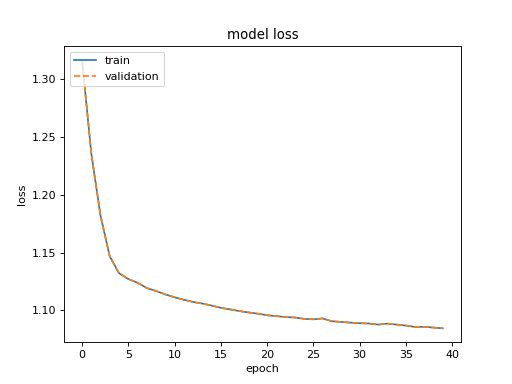

In [128]:
plot_loss(val_loss, train_loss)

In [43]:
rnn_model(X_train, y_train, 8, 0.01).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 (None, 8)                 384       
_________________________________________________________________
dense_48 (Dense)             (None, 3)                 27        
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________


In [42]:
rnn_2layers_model(X_train, y_train, 8, 0.01).summary()

128 7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_25 (GRU)                 (None, 8)                 384       
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_47 (Dense)             (None, 3)                 15        
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________


In [134]:
test_subject = '03'
train_subjects = ['01','02']

results = []
for path in all_paths:    
    train_data, _, train_anots, test_data, _, test_annoations = read_filter(path, train_subjects, test_subject, columns_to_read, cutoff_beggining, seq_len, cut_step)
    train_data = flilter_chanels(train_data, chanels_rank)
    test_data = flilter_chanels(test_data, chanels_rank)
    
    n_values = np.max(train_anots) + 1
    y_train_hot = np.eye(n_values)[train_anots]
    y_test_hot = np.eye(n_values)[test_annoations]
    
    X_train, y_train = cut_data(train_data, y_train_hot)
    X_test, y_test = cut_data(test_data, y_test_hot)

    max_element = X_train.max()
    min_element =  X_train.min()
    
    X_train = (X_train-min_element)/(max_element-min_element)
    X_test =(X_test-min_element)/(max_element-min_element)

    
    model = rnn_model(X_train, y_train, hiden_size=6, regularization=0.008)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, verbose=0)
    
    hist = history.history
    results.append(hist)

In [141]:
mean_train_acc = np.zeros(len(results[0]['val_loss']))
mean_test_acc = np.zeros(len(results[0]['val_loss']))
mean_train_loss = np.zeros(len(results[0]['val_loss']))
mean_test_loss = np.zeros(len(results[0]['val_loss']))

for person_res  in results:
    mean_train_acc += np.array(person_res['acc'])
    mean_test_acc += np.array(person_res['val_acc'])
    mean_train_loss += np.array(person_res['loss'])
    mean_test_loss += np.array(person_res['val_loss'])

mean_train_acc /= 3
mean_test_acc /= 3
mean_train_loss /= 3
mean_test_loss /= 3
    

<IPython.core.display.Javascript object>


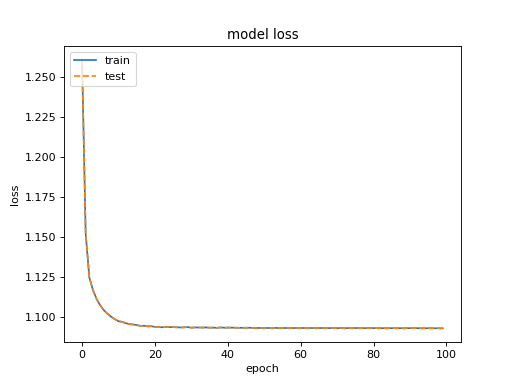

In [148]:
plot_loss(mean_test_loss, mean_train_loss)

In [149]:
mean_train_acc[-1],mean_test_acc[-1]

(0.3619095713379889, 0.3796143441499864)